# <font color='blue'> PPHA 30546 Machine Learning | Mini Project 2 </font> 

## 1. Motivation

The capacity of the government to collect taxes is pivotal to long-run economic growth because without tax revenue, the state cannot provide public goods. One way the government can increase tax revenue is by increasing the tax rate. Another way to increase tax revenue is by reducing the probability of successful tax evasion; as probability of success decreases, the incentive to cheat
gets weaker. The government can reduce the probability of successful tax evasion by simply increasing the number of audits it performs. However, increasing the number of audits also increases government expenditure, which may offset the increase in tax revenue. Another way to reduce the probability of successful tax evasion is to better target audits. That is, the government can increase the probability of catching tax evasion by reducing the number of audits performed on firms that paid their taxes and increasing the number of audits performed on firms that evaded their taxes. How might the government go about such an effort? 

This is a prediction problem, so the government can approach this effort using the machine learning techniques we’re covering in class! For instance, one way the government can become more adept at going after firms that were dishonest on their taxes is by using a Linear Probability Model (LPM) or k-Nearest Neighbors (KNN). Firms that evade taxes might display similar characteristics, allowing the government to predict whether a firm has evaded taxes with a low classification error
rate.

The dataset you’ll use for this project contains information on firms that the government of India suspected of tax evasion and subsequently the Comptroller and Auditor General (CAG) of India performed audits on. Table 1 contains the variable names and their definitions. The outcome variable is whether the auditor found that the firm evaded taxes as a result of the audit (Risk). The predictors include various quantitative measures about the firms.


In [92]:
# Import the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sympy import symbols, Eq, solve, exp

from IPython.display import Image
from IPython.core.display import HTML 

import warnings
warnings.filterwarnings('ignore')

## 2. Forest-for-the-Trees Questions

### 1. Since it’s important to use theory/intuition/common sense in concert with our data driven approaches, what factors do you suspect will affect the true, underlying model of whether or not a firm will commit tax evasion? Briefly explain.

This is an open-ended question designed to get you to think about the task at hand in general. You are not limited to the list of available predictors in answering this question.

<font color='blue'> Based on my experience to detect fraud risks of public comps, there are so many ways to whitewash the financial statement. I believe that the underlying causes of these discrepancies can be attributed to sector-specific risks, variances between projected and actual expenditures, and certain characteristics of firms that facilitate tax evasion. Factors such as risk assessments and historical auditing data may serve as indicators of these foundational issues.

Discrepancies on the financial statements: Significant deviations between budgeted and actual spending can elevate financial vulnerabilities. Moreover, the risk escalates when there is an unexplained substantial increase in a company's stock and revenue within a single year (compare yoy growth).

Sector-specific risk: Certain industries are more prone to tax evasion strategies, indicating a heightened level of risk inherent to those sectors.

Unmatching revenue growth compared to competitors: Discrepancies in operational and financial performance compared to industry benchmarks—such as growth rates, gross margins, and liquidity ratios—requires scrutiny.

Historical audit/risk assessment: A good indicator for future risks.

### 2. Assume that in addition to some combination of the predictors listed in Table 1, the interaction of two predictor variables also enters the true model. If the appropriate interaction is not explicitly included as a predictor in the fitted model, what advantage does KNN enjoy over the LPM if the interaction is indeed important to the true relationship?

<font color='blue'> LPM is a linear model that one must explicitly feed interaction terms for these nuanced relationships to be noticed. However, KNN is a non-parametric model that does not assume a specific form for the relationship between predictors and the outcome, being more flexible. It estimates f(x0) using the average of all the training responses in N0. This approach allows KNN to naturally account for complex interactions between predictors without the need to explicitly model these interactions, which improves accuracy and reduces bias when the true relationship includs the interaction.

## 3 Data Analysis

### 3. Split the sample set into a training set and a validation set. Use the training set to fit a linear probability model (LPM). Apply the model to the second half of the data to predict the probability a firm cheated.

Please use a 50/50 training/validation set split and set random_state=13.

### <font color='blue'>  Preprossing

We only have one N/A value under `Money_Value` column, but by examining descripive statistics, I believe it would be the best to remove this row considering how spread out money values are with std = 66.6 to be filled in with any values. 

By checking data types, all variables are floats so we can use the standard scalar.



In [60]:
# Read in the data
audit = pd.read_csv('data//Data-Audit.csv')
print(audit.shape)
audit.head()

(776, 11)


,Sector_score,PARA_A,Risk_A,PARA_B,Risk_B,Money_Value,Risk_D,Score,Inherent_Risk,Audit_Risk,Risk
0,3.89,4.18,2.508,2.50,0.500,3.38,0.676,2.4,8.574,1.7148,1
1,3.89,0.00,0.000,4.83,0.966,0.94,0.188,2.0,2.554,0.5108,0
2,3.89,0.51,0.102,0.23,0.046,0.00,0.000,2.0,1.548,0.3096,0
3,3.89,0.00,0.000,10.80,6.480,11.75,7.050,4.4,17.530,3.5060,1
4,3.89,0.00,0.000,0.08,0.016,0.00,0.000,2.0,1.416,0.2832,0


In [61]:
# Descriptive Statistics
pd.set_option('display.max_columns', None) # no column will be hidden in output
audit.describe()

,Sector_score,PARA_A,Risk_A,PARA_B,Risk_B,Money_Value,Risk_D,Score,Inherent_Risk,Audit_Risk,Risk
count,776.000000,776.000000,776.000000,776.000000,776.000000,775.000000,776.000000,776.000000,776.000000,776.000000,776.000000
mean,20.184536,2.450194,1.351029,10.799988,6.334008,14.137631,8.265434,2.702577,17.680612,7.168158,0.393041
std,24.319017,5.678870,3.440447,50.083624,30.072845,66.606519,39.970849,0.858923,54.740244,38.667494,0.488741
min,1.850000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.400000,0.280000,0.000000
25%,2.370000,0.210000,0.042000,0.000000,0.000000,0.000000,0.000000,2.000000,1.583500,0.316700,0.000000
50%,3.890000,0.875000,0.175000,0.405000,0.081000,0.090000,0.018000,2.400000,2.214000,0.555600,0.000000
75%,55.570000,2.480000,1.488000,4.160000,1.840500,5.595000,2.235000,3.250000,10.663500,3.249900,1.000000
max,59.850000,85.000000,51.000000,1264.630000,758.778000,935.030000,561.018000,5.200000,801.262000,961.514400,1.000000


In [62]:
# Check for missing values
na_count = pd.DataFrame(np.sum(audit.isna(), axis = 0), columns = ["Count NAs"])
print(na_count)
audit[audit['Money_Value'].isna()]

               Count NAs
Sector_score           0
PARA_A                 0
Risk_A                 0
PARA_B                 0
Risk_B                 0
Money_Value            1
Risk_D                 0
Score                  0
Inherent_Risk          0
Audit_Risk             0
Risk                   0


,Sector_score,PARA_A,Risk_A,PARA_B,Risk_B,Money_Value,Risk_D,Score,Inherent_Risk,Audit_Risk,Risk
642,55.57,0.23,0.046,0.0,0.0,NaN,0.0,2.0,1.446,0.2892,0


In [63]:
# Drop the NA value in Money_Value
audit = audit[audit['Money_Value'].notna()]
pd.DataFrame(np.sum(audit.isna(), axis = 0), columns = ["Count NAs"])

,Count NAs
Sector_score,0
PARA_A,0
Risk_A,0
PARA_B,0
Risk_B,0
Money_Value,0
Risk_D,0
Score,0
Inherent_Risk,0
Audit_Risk,0


In [64]:
# Splitting data
X = audit.drop(columns = ['Risk'])
target = audit.loc[:,'Risk']
display(X.head())
display(target.head())

,Sector_score,PARA_A,Risk_A,PARA_B,Risk_B,Money_Value,Risk_D,Score,Inherent_Risk,Audit_Risk
0,3.89,4.18,2.508,2.50,0.500,3.38,0.676,2.4,8.574,1.7148
1,3.89,0.00,0.000,4.83,0.966,0.94,0.188,2.0,2.554,0.5108
2,3.89,0.51,0.102,0.23,0.046,0.00,0.000,2.0,1.548,0.3096
3,3.89,0.00,0.000,10.80,6.480,11.75,7.050,4.4,17.530,3.5060
4,3.89,0.00,0.000,0.08,0.016,0.00,0.000,2.0,1.416,0.2832


0    1
1    0
2    0
3    1
4    0
Name: Risk, dtype: int64

In [65]:
# Check data types
X.dtypes  

Sector_score     float64
PARA_A           float64
Risk_A           float64
PARA_B           float64
Risk_B           float64
Money_Value      float64
Risk_D           float64
Score            float64
Inherent_Risk    float64
Audit_Risk       float64
dtype: object

In [66]:
# Splitting testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.50, random_state=13)

In [67]:
# Fit the LPM
model_lpm = LinearRegression(fit_intercept=True)
model_lpm.fit(X_train, y_train)

# Predict the labels on the test set
y_pred_lpm = model_lpm.predict(X_test)

# 10 first predictions
y_pred_lpm[:10]

array([0.93084416, 0.11823158, 0.12403531, 0.53915841, 0.25448992,
       1.03733079, 0.92258489, 0.11778926, 0.56594786, 1.69933872])

### (a) For firms with a predicted probability of tax evasion greater than 0.5, construct the confusion matrix.

In [68]:
# Continuous to binary predictions
y_pred_lpm_bin_5 = np.where(y_pred_lpm > 0.5, 1, 0)
y_pred_lpm_bin_5[:10]

array([1, 0, 0, 1, 0, 1, 1, 0, 1, 1])

In [69]:
# Generate the condusion matrix
cm_lpm_5 = confusion_matrix(y_test, y_pred_lpm_bin_5)
cm_lpm_5_norm = confusion_matrix(y_test, y_pred_lpm_bin_5, normalize = 'true')
print(cm_lpm_5)
print(cm_lpm_5_norm)

[[221   8]
 [ 29 130]]
[[0.9650655  0.0349345 ]
 [0.18238994 0.81761006]]


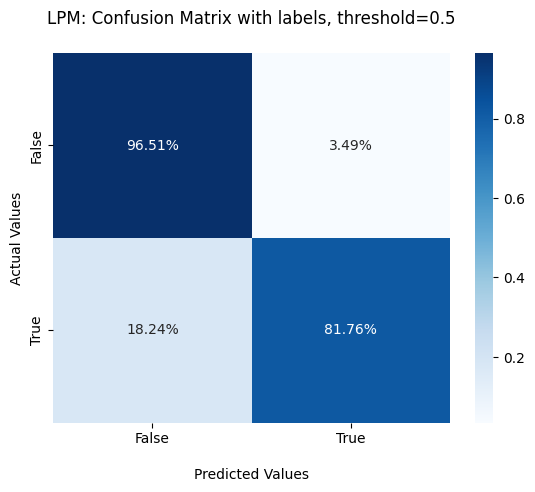

In [70]:
# Draw the heatmap
ax = sns.heatmap(cm_lpm_5_norm, annot=True, fmt='.2%', cmap='Blues')

ax.set_title('LPM: Confusion Matrix with labels, threshold=0.5\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

### (b) For firms with a predicted probability of tax evasion greater than 0.6, construct the confusion matrix.

In [71]:
# Continuous to binary predictions
y_pred_lpm_bin_6 = np.where(y_pred_lpm > 0.6, 1, 0)
y_pred_lpm_bin_6[:10]

array([1, 0, 0, 0, 0, 1, 1, 0, 0, 1])

In [72]:
# Generate the condusion matrix
cm_lpm_6 = confusion_matrix(y_test, y_pred_lpm_bin_6, normalize = 'true')
print(cm_lpm_6)

[[0.98253275 0.01746725]
 [0.24528302 0.75471698]]


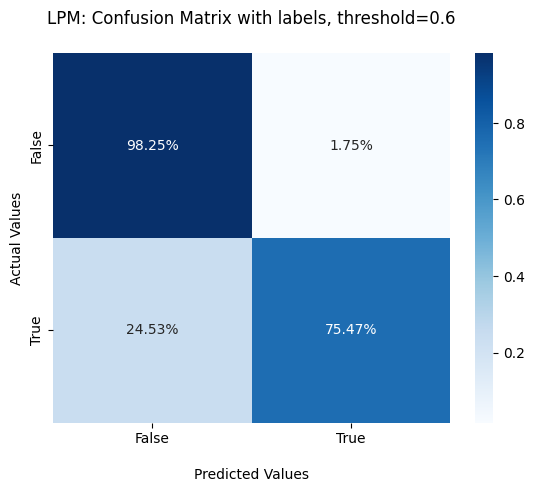

In [73]:
# Draw the heatmap
ax = sns.heatmap(cm_lpm_6, annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('LPM: Confusion Matrix with labels, threshold=0.6\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

### (c) For each of the two thresholds, report the error rate. Which results in more accurate overall predictions?

<font color='blue'>  Error rates for threshold = 0.5 is 9.54%, for threshold = 0.6 is 11.08%, so the lower threshold = 0.5 results in more accurate overall predictions. It is worth noticing that threshold = 0.6 better predict the False values.

In [74]:
# Initialize accuracy tracking dictionary
accuracies = {} 

# Compute the accuracy
accuracies['LPM with 0.5 threshold'] = accuracy_score(y_test, y_pred_lpm_bin_5)
accuracies['LPM with 0.6 threshold'] = accuracy_score(y_test, y_pred_lpm_bin_6)

# Print the accuracies
for model, accuracy in accuracies.items():
    print(f'{model} accuracy: {round(accuracy, 4)*100}%')
    print(f'{model} error rate: {round(1-accuracy, 4)*100}%')

LPM with 0.5 threshold accuracy: 90.46%
LPM with 0.5 threshold error rate: 9.54%
LPM with 0.6 threshold accuracy: 88.92%
LPM with 0.6 threshold error rate: 11.08%


### (d) For each of the two thresholds, what proportion of the firms predicted to evade their taxes actually evaded taxes?

<font color='blue'> For threshold = 0.5 and 0.6, 81.76% and 75.47% of the firms predicted to evade their taxes actually evaded taxes respectively.

### 4. In measuring performance in this context, should a false negative matter as much as a false positive? Briefly explain why or why not and how changing the threshold for classifying a firm as a tax evader (as in the previous question) affects this trade-off.

<font color='blue'> 
A false negative occurs when a model incorrectly predicts that a firm will not evade taxes when it does, which suggests a potential tax evader goes undetected, leading to lost revenue for the government and undermining the fairness of the tax system.

A false positive occurs when a model incorrectly predicts that a firm will evade taxes when it does not, which could lead to unnecessary audits, wasting resources and potentially harming the reputation and operations of compliant firms.

The relative cost of FNs and FPs is contingent upon policy objectives, leading to a trade-off. If the government aims to maximize tax revenue collection and discourage evasion, it might prioritize minimizing FNs, even at the risk of increasing FPs. Conversely, if minimizing disruption to compliant businesses is a priority, the government might seek to minimize FPs. In the context of preventing financial fraud and ensuring tax compliance, I believe that the impact of FNs outweighs that of FPs, as it is critical to prevent entities engaged in financial misconduct from evading tax obligations.

The data derived from the confusion matrices illustrates this trade-off: as the threshold increases, FNs escalate from 18.24% to 24.53%, while FPs diminish from 3.49% to 1.75%. The higher the threshold, the lower the false positives since we raised the standard of being identified 1. Lowering threshold by 0.1 effectively reduced FN by 6.29 pp. Preferring a lower threshold aligns with valuing the reduction of FNs more highly, aiming to mitigate the risk of overlooking tax evasion.

### 5. Using the training set from the previous question, fit a KNN model with k = 5, then use it to predict outcomes in the validation set.

### (a) Construct the confusion matrix.

In [75]:
# KNN with 5 neighbors
model_knn = KNeighborsClassifier(n_neighbors = 5)
model_knn.fit(X_train, y_train)

# Predict the labels on the test set
y_pred_knn = model_knn.predict(X_test)

# 10 first predictions
y_pred_knn[:10]

array([1, 0, 0, 1, 0, 1, 1, 0, 1, 1], dtype=int64)

In [76]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_knn_norm = confusion_matrix(y_test, y_pred_knn, normalize = 'true')
print(cm_knn)
print(cm_knn_norm)

[[226   3]
 [ 11 148]]
[[0.98689956 0.01310044]
 [0.06918239 0.93081761]]


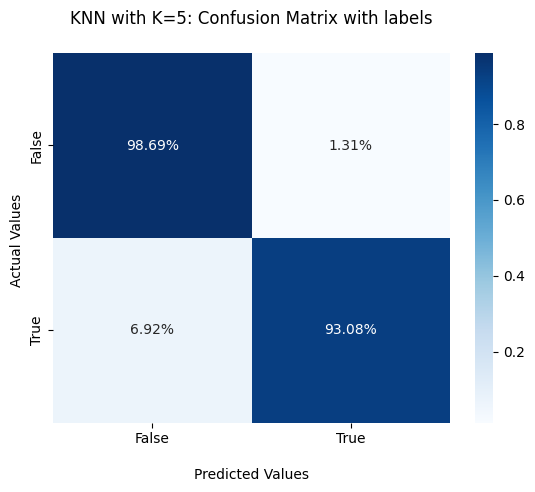

In [77]:
# Draw the heatmap
ax = sns.heatmap(cm_knn_norm, annot=True, fmt='.2%', cmap='Blues')

ax.set_title('KNN with K=5: Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

### (b) Report the error rate. How accurate are the overall predictions?

<font color='blue'> The error rate is 3.61%, lower than both from the LPM. The accuracy is notably high, reaching 96.39%.

In [78]:
# Compute the accuracy
accuracies['KNN with K=5'] = accuracy_score(y_test, y_pred_knn)

# Print the accuracies
for model, accuracy in accuracies.items():
    print(f'{model} accuracy: {round(accuracy, 4)*100}%')
    print(f'{model} error rate: {round(1-accuracy, 4)*100}%')

LPM with 0.5 threshold accuracy: 90.46%
LPM with 0.5 threshold error rate: 9.54%
LPM with 0.6 threshold accuracy: 88.92%
LPM with 0.6 threshold error rate: 11.08%
KNN with K=5 accuracy: 96.39%
KNN with K=5 error rate: 3.61%


### (c) What proportion of the firms predicted to evade their taxes actually evaded taxes?

<font color='blue'> Reading true positives from the confusion matrix, 93.08% of the firms predicted to evade their taxes actually evaded taxes.

### 6. Repeat the previous question with k = 5 after normalizing the data.

There are several ways to scale or normalize variables. Normalization here refers to scaling each attribute so that the mean is zero and the variance is 1. There is a trade-off between normalizing before splitting into training and validation sets or after. The former uses more precise estimates of the population mean and variance. The latter does not bring information from the validation set into the training set (which could result in inadvertent overfitting). Given the sample size in this question, you should normalize before splitting your data.

In [79]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
cols = X.columns
X_final = pd.DataFrame(X_scaled, columns=cols)
X_final.head()

,Sector_score,PARA_A,Risk_A,PARA_B,Risk_B,Money_Value,Risk_D,Score,Inherent_Risk,Audit_Risk
0,-0.669071,0.304129,0.335827,-0.166006,-0.194273,-0.161614,-0.190146,-0.353484,-0.166753,-0.141265
1,-0.669071,-0.432005,-0.393216,-0.119482,-0.178777,-0.198271,-0.202356,-0.819385,-0.276733,-0.172402
2,-0.669071,-0.342190,-0.363566,-0.211331,-0.209370,-0.212393,-0.207059,-0.819385,-0.295112,-0.177606
3,-0.669071,-0.432005,-0.393216,-0.000278,0.004583,-0.035870,-0.030676,1.976022,-0.003134,-0.094940
4,-0.669071,-0.432005,-0.393216,-0.214326,-0.210368,-0.212393,-0.207059,-0.819385,-0.297523,-0.178289


In [80]:
# View the summary statistics table
pd.set_option('display.max_columns', None) # no column will be hidden in output
X_final.describe()

,Sector_score,PARA_A,Risk_A,PARA_B,Risk_B,Money_Value,Risk_D,Score,Inherent_Risk,Audit_Risk
count,7.750000e+02,7.750000e+02,7.750000e+02,775.000000,775.000000,7.750000e+02,7.750000e+02,7.750000e+02,775.000000,7.750000e+02
mean,-2.933854e-16,2.750488e-17,9.168293e-18,0.000000,0.000000,9.168293e-18,9.168293e-18,2.200390e-16,0.000000,1.833659e-17
std,1.000646e+00,1.000646e+00,1.000646e+00,1.000646,1.000646,1.000646e+00,1.000646e+00,1.000646e+00,1.000646,1.000646e+00
min,-7.530708e-01,-4.320051e-01,-3.932159e-01,-0.215924,-0.210900,-2.123930e-01,-2.070591e-01,-8.193847e-01,-0.297815,-1.783714e-01
25%,-7.316591e-01,-3.950223e-01,-3.810070e-01,-0.215924,-0.210900,-2.123930e-01,-2.070591e-01,-8.193847e-01,-0.294454,-1.774197e-01
50%,-6.690709e-01,-2.770294e-01,-3.420550e-01,-0.207737,-0.208173,-2.110409e-01,-2.066088e-01,-3.534837e-01,-0.282944,-1.712335e-01
75%,1.458927e+00,4.744574e-03,3.932634e-02,-0.132860,-0.148151,-1.283380e-01,-1.510667e-01,6.947938e-01,-0.127858,-1.014939e-01
max,1.635163e+00,1.453724e+01,1.443182e+01,25.035204,25.021157,1.383479e+01,1.382901e+01,2.907824e+00,14.314970,2.468112e+01


In [81]:
# Splitting testing and training data
X_train, X_test, y_train, y_test = train_test_split(X_final, target, test_size=0.50, random_state=13)

In [82]:
# KNN with 5 neighbors
model_knn = KNeighborsClassifier(n_neighbors = 5)
model_knn.fit(X_train, y_train)

# Predict the labels on the test set
y_pred_knn = model_knn.predict(X_test)

# 10 first predictions
y_pred_knn[:10]

array([1, 0, 0, 0, 0, 1, 1, 0, 1, 1], dtype=int64)

### (a) Construct the confusion matrix.

In [83]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_knn_norm = confusion_matrix(y_test, y_pred_knn, normalize = 'true')
print(cm_knn)
print(cm_knn_norm)

[[222   7]
 [ 15 144]]
[[0.96943231 0.03056769]
 [0.09433962 0.90566038]]


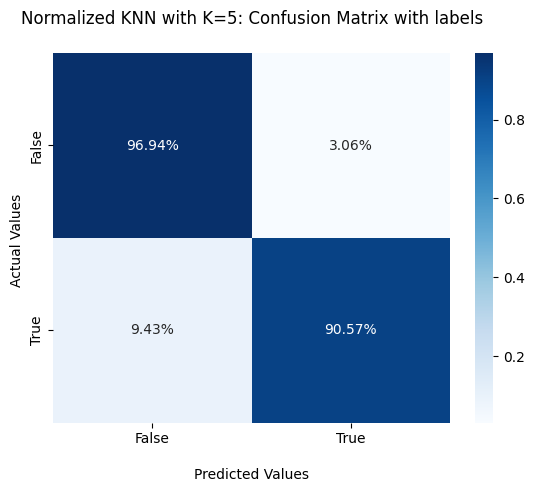

In [84]:
# Draw the heatmap
ax = sns.heatmap(cm_knn_norm, annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Normalized KNN with K=5: Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

### (b) Report the error rate. How accurate are the overall predictions?

<font color='blue'> The error rate is 5.67%, high than that of the the non-normalized KNn. The accuracy is slightly lower, at 94.33%.

In [85]:
# Compute the accuracy
accuracies['Normalized KNN with K=5'] = accuracy_score(y_test, y_pred_knn)

# Print the accuracies
for model, accuracy in accuracies.items():
    print(f'{model} accuracy: {round(accuracy, 4)*100}%')
    print(f'{model} error rate: {round(1-accuracy, 4)*100}%')

LPM with 0.5 threshold accuracy: 90.46%
LPM with 0.5 threshold error rate: 9.54%
LPM with 0.6 threshold accuracy: 88.92%
LPM with 0.6 threshold error rate: 11.08%
KNN with K=5 accuracy: 96.39%
KNN with K=5 error rate: 3.61%
Normalized KNN with K=5 accuracy: 94.33%
Normalized KNN with K=5 error rate: 5.67%


### (c) What proportion of the firms predicted to evade their taxes actually evaded taxes?

<font color='blue'> Reading true positives from the confusion matrix, 90.57% of the firms predicted to evade their taxes actually evaded taxes.

### 7. Which KNN model performs better: with or without the predictors normalized? Briefly explain how you make this determination and why you think this is the case.

<font color='blue'> The KNN model without the predictors nomalized performs better in general, with lower false negatives and lower false positives.

### 8. For KNN, which k yields the lowest error rate? By 5-fold cross-validation (5FCV), find the k with the lowest classification error rate.

Use the entire dataset for 5FCV, shuffle the data randomly for splitting, and set random_state=13. You do not need to normalize the data for this question.

<font color='blue'> k=1 gives the lowest classification error rate of 2.06%.

In [101]:
# Approximate upper bound of k
# Roughly the square-root of the number of samples in our training set
np.sqrt(len(X))

27.83882181415011

In [110]:
ks = list(range(1, 27))
para = {'n_neighbors': ks}

# Initialize the KNN classifier
knni = KNeighborsClassifier()

# Set up 5-fold cross-validation scheme
knn_cv = GridSearchCV(knni, para, cv=KFold(5, random_state=13, shuffle=True), scoring='accuracy')

# Fit the model
knn_cv.fit(X, target)

print("Best parameters:", knn_cv.best_params_)
print("Best cross-validation score:", f'{round(knn_cv.best_score_, 4)*100}%')
print("Lowest classfication error rate:", f'{round(1-knn_cv.best_score_, 4)*100}%')

Best parameters: {'n_neighbors': 1}
Best cross-validation score: 97.94%
Lowest classfication error rate: 2.06%
